In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import matplotlib.pyplot as plt
# import graphviz
from sklearn.metrics import r2_score
import pickle
from mlp import MLP
from mlba_nn import MLBA_NN
import json
from pathlib import Path

In [2]:
features = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
train_data = pd.read_csv('data/E2.csv')
e1a = pd.read_csv('data/E1a.csv')
e1b = pd.read_csv('data/E1b.csv')
e1c = pd.read_csv('data/E1c.csv')
e3a = pd.read_csv('data/E3a.csv')
e3b = pd.read_csv('data/E3b.csv')
e3c = pd.read_csv('data/E3c.csv')

## Train a model

In [3]:
X_train = train_data[features].values
y_train = train_data.response.values - 1

In [4]:
def train(model, name):
    model.fit(X_train, y_train)
    p = Path('out/models')
    p.mkdir(exist_ok=True, parents=True)
    
    p = p / name + '.pkl'
    with p.open('wb') as f:
        pickle.dump(model, f)

In [5]:

# model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# model = RandomForestClassifier(n_estimators=100)
# model = tree.DecisionTreeClassifier(max_depth=5)
# model = SVC(probability=True, gamma='auto')
# model = BayesianLogisticRegression(10000)
# model = MLP(6, 3, 50, 100, 32)
# model = MLBA_NN(6, 3, 50, 100, 32)
# model = model.fit(X_train, y_train)

In [6]:
# X = fine_tune_data[features].values
# y = fine_tune_data.response.values - 1
# model.lr = 0.0001
# model.epochs = 50
# model = model.fit(X, y)

## Results

In [7]:
def get_freq(x):
    hist, _ = np.histogram(x, 3)
    return hist/hist.sum()
    
def predict(model, data):
    X_test = data[features].values
    y_test = data.response.values - 1
    actual_freq = get_freq(y_test)
    pred_freq = model.predict_proba(X_test).mean(0)
    return actual_freq, pred_freq, ((actual_freq - pred_freq) ** 2).mean()

In [8]:
def get_predictions(model, data):
    MSE = []
    actual = []
    pred = []
    for d in data:
        actual_freq, pred_freq, mse = predict(model, d)
        MSE.append(mse)
        actual.append(actual_freq)
        pred.append(pred_freq)

    actual = np.array(actual)
    pred = np.array(pred)
    return actual, pred, MSE

In [9]:
markers = ['o', '^', 'd', 's', '.', '*', 'x', 'p', 'h', 'v']
colors = ['r', 'lime', 'b']
def plot_results(actual, pred, labels=None, c=1):
    plt.figure(figsize=[4.8, 4.8])
    for i in range(3):
        x, y = actual[:, i], pred[:, i]
        for j in range(len(x)):
            plt.scatter(x[j], y[j], marker=markers[j], c=colors[c])
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.legend(labels)
    plt.plot([0, 1], [0, 1])
    plt.xlim(0, 1)
    plt.ylim(0, 1)

### Train Results

In [10]:
# train_effects = [d for _, d in train_data.groupby('Effect')]
# actual, pred, mse = get_predictions(model, train_effects)
# plot_results(actual, pred)
# mse

### Test results

#### Attraction

In [11]:
# e1a_effects = [d for _, d in e1a.groupby('Effect')]
# actual, pred, mse = get_predictions(model, [*e1a_effects])
# plot_results(actual, pred, 0)
# np.mean(mse)

#### Compromise

In [12]:
# e1b_effects = [d for _, d in e1b.groupby('Effect')]
# actual, pred, mse = get_predictions(model, [*e1b_effects])
# plot_results(actual, pred, 0)
# np.mean(mse)

#### Similarity

In [13]:
# e1c_effects = [d for _, d in e1c.groupby('Effect')]
# actual, pred, mse = get_predictions(model, [*e1c_effects])
# plot_results(actual, pred, 0)
# np.mean(mse)

# Paper results

In [14]:
cols = ['Cond', 'Time', 'Resp.O1', 'Resp.O2', 'Resp.O3']
def load_paper_data(path):
    with open(path) as f:
        data = json.load(f)
    data = [[s[k] for k in cols] for u in data for s in u]
    data = pd.DataFrame(data=data, columns=cols)
    return data.rename(columns={'Cond': 'Effect'})

experimentData = {
    'e1a': (e1a, load_paper_data('hb_mlba/e1a.pred.json')),
    'e1b': (e1b, load_paper_data('hb_mlba/e1b.pred.json')),
    'e1c': (e1c, load_paper_data('hb_mlba/e1c.pred.json')),
    'e3a': (e3a, load_paper_data('hb_mlba/e3a.pred.json')),
    'e3b': (e3b, load_paper_data('hb_mlba/e3b.pred.json')),
    'e3c': (e3c, load_paper_data('hb_mlba/e3c.pred.json')),
}

In [15]:

def get_paper_predictions(exp):
    actual, pred = experimentData[exp]   
    effects = sorted(actual.Effect.unique())
    actual = np.array([get_freq(actual[actual.Effect == e].response.values - 1) for e in effects])
    pred = np.array([pred[pred.Effect == e][['Resp.O1', 'Resp.O2', 'Resp.O3']].values.mean(0) for e in effects])
    for i in range(len(effects)):
        print(effects[i])
        print(actual[i])
        print(pred[i])
    mse = ((actual - pred) ** 2).mean(1)
    return actual, pred, mse.tolist(), effects

#### Attraction e1

AttF1
[0.45863386 0.4433602  0.09800594]
[0.40609231 0.34039932 0.25350836]
AttF2
[0.44685374 0.46130952 0.09183673]
[0.40720653 0.36190119 0.23089228]
AttR1
[0.54796265 0.40004244 0.05199491]
[0.44103792 0.35142097 0.2075411 ]
AttR2
[0.49968173 0.44493953 0.05537874]
[0.43614606 0.38744769 0.17640626]
AttRF1
[0.4942602  0.41751701 0.08822279]
[0.41294876 0.34111645 0.24593479]
AttRF2
[0.46498302 0.45267402 0.08234295]
[0.41484964 0.36780347 0.21734689]
28259


0.010754352170205516

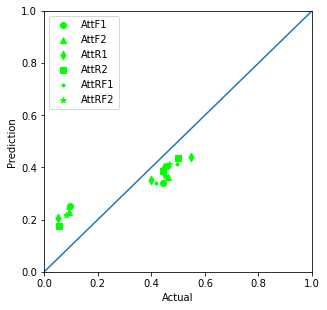

In [27]:
actual, pred, mse, effects = get_paper_predictions('e1a')
plot_results(actual, pred, effects)
e1a_mse = np.mean(mse)
print(e1a.shape[0])
e1a_mse

#### Compromise e1

Com1
[0.18180991 0.29977262 0.51841746]
[0.30721022 0.33411243 0.35867735]
Com2
[0.27446344 0.53328483 0.19225173]
[0.29185147 0.33605347 0.37209506]
21991


0.018994590045915402

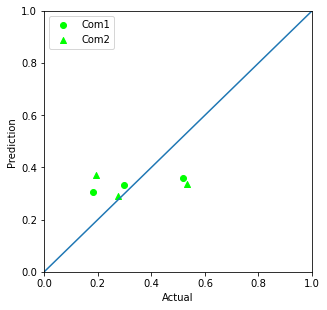

In [28]:
actual, pred, mse, effects = get_paper_predictions('e1b')
plot_results(actual, pred, effects)
e1b_mse = np.mean(mse)
print(e1b.shape[0])
e1b_mse

#### Similarity e1

SimA1
[0.30215132 0.42144066 0.27640803]
[0.33863984 0.32259061 0.33876955]
SimA2
[0.31476559 0.32781537 0.35741904]
[0.34114232 0.3320597  0.32679797]
SimB1
[0.32365396 0.40907441 0.26727163]
[0.33066123 0.34830386 0.3210349 ]
SimB2
[0.33160246 0.32363241 0.34476512]
[0.31740275 0.3400858  0.34251145]
33096


0.001979431281793484

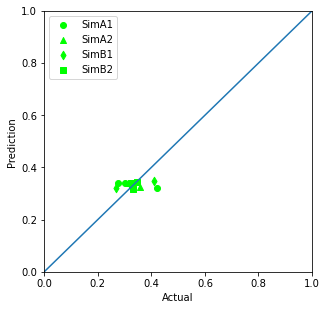

In [35]:
actual, pred, mse, effects = get_paper_predictions('e1c')
plot_results(actual, pred, effects)
e1c_mse = np.mean(mse)
print(e1c.shape[0])
e1c_mse

### Overall e1

In [36]:
(e1a_mse * e1a.shape[0] + e1b_mse * e1b.shape[0] + e1c_mse * e1c.shape[0]) / (e1a.shape[0] + e1b.shape[0] + e1c.shape[0])

0.009444106800323955

Attraction e3

AttF1
[0.44893617 0.44468085 0.10638298]
[0.36989149 0.36612021 0.2639883 ]
AttF2
[0.32340426 0.55212766 0.12446809]
[0.35218936 0.38344894 0.2643617 ]
AttR1
[0.49680851 0.41808511 0.08510638]
[0.37530532 0.36520319 0.25949149]
AttR2
[0.34468085 0.57978723 0.07553191]
[0.351      0.39064681 0.25835319]
AttRF1
[0.45319149 0.45425532 0.09255319]
[0.40539574 0.39249255 0.2021117 ]
AttRF2
[0.34148936 0.55425532 0.10425532]
[0.37510426 0.41921915 0.2056766 ]
5640


0.013948392935340276

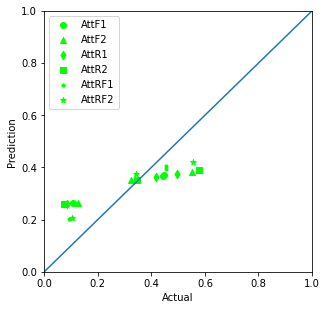

In [38]:
actual, pred, mse, effects = get_paper_predictions('e3a')
plot_results(actual, pred, effects)
e3a_mse = np.mean(mse)
print(e3a.shape[0])
e3a_mse

### Compromise e3

Com1
[0.16490385 0.23365385 0.60144231]
[0.31792933 0.33919087 0.34287981]
Com2
[0.19519231 0.72740385 0.07740385]
[0.33099904 0.34195625 0.32704471]
Com3
[0.66586538 0.21153846 0.12259615]
[0.34640817 0.33896442 0.3146274 ]
6240


0.0539899547140553

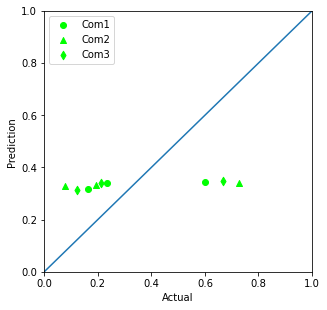

In [40]:
actual, pred, mse, effects = get_paper_predictions('e3b')
plot_results(actual, pred, effects)
e3b_mse = np.mean(mse)
print(e3b.shape[0])
e3b_mse

### Similarity e3

SimA1
[0.12875817 0.68169935 0.18954248]
[0.32390654 0.3560549  0.32003856]
SimA2
[0.34313725 0.39934641 0.25751634]
[0.31082876 0.34476405 0.34440719]
SimB1
[0.16143791 0.62679739 0.21176471]
[0.32655425 0.34949542 0.32395033]
SimB2
[0.36405229 0.48366013 0.15228758]
[0.31670915 0.34224379 0.34104706]
6120


0.028945416510814934

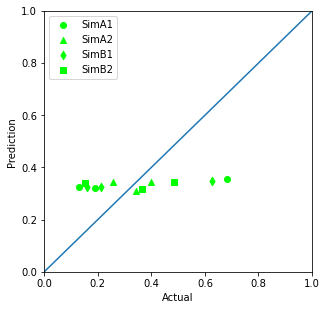

In [41]:
actual, pred, mse, effects = get_paper_predictions('e3c')
plot_results(actual, pred, effects)
e3c_mse = np.mean(mse)
print(e3c.shape[0])
e3c_mse

### Overall e3

In [42]:
(e3a_mse * e3a.shape[0] + e3b_mse * e3b.shape[0] + e3c_mse * e3c.shape[0]) / (e3a.shape[0] + e3b.shape[0] + e3c.shape[0])

0.0329284557009562